In [157]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans
import metrics
from ConvAE import CAE
from sklearn.preprocessing import StandardScaler
from DCEC import DCEC
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [158]:
x = np.load('../DL-WORKSHOP/npy_files/features_All16.npy')
x.shape

(29808, 16, 5)

In [66]:
new_shape = x[:,:,:4].shape

In [67]:
x_n = np.zeros(new_shape)

In [68]:
x_n[:,:,:2] = x[:,:,:2]
x_n[:,:,-2:] = x[:,:,-2:]
x_n.shape

(29808, 16, 4)

In [159]:
traj = x[:,:,:2]
traj.shape

(29808, 16, 2)

In [161]:
x_mod = traj.copy()
x_mod.shape

(29808, 16, 2)

In [162]:
for j in range(traj.shape[0]):
    for i in range(traj.shape[1]-1):
        x_mod[j,i,0] = (np.sqrt( (traj[j,i+1,1]-traj[j,i,1])**2 + (traj[j,i+1,0]-traj[j,i,0])**2 ))
        x_mod[j,i,1] = np.arctan( (traj[j,i+1,1]-traj[j,i,1])/(traj[j,i+1,0]-traj[j,i,0]) )
    x_mod[j,-1,:] = x_mod[j,-2,:]

C:\Users\asafavra\AppData\Local\Temp\ipykernel_4536\1260729646.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  x_mod[j,i,1] = np.arctan( (traj[j,i+1,1]-traj[j,i,1])/(traj[j,i+1,0]-traj[j,i,0]) )


In [69]:
X_train = x_n.copy()

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

In [71]:
X_train[0,:,:]

array([[-0.02689277,  0.06141436,  0.00979852,  0.84705615],
       [-0.11429255, -0.2250968 ,  0.39794725,  0.99427139],
       [ 0.08175791, -0.4024743 ,  0.17476144,  0.99206308],
       [ 0.42730953, -0.106489  ,  0.19082252,  0.76444655],
       [-0.79437573, -0.50739375,  0.18535067,  0.35839469],
       [-0.19518843, -0.36945442,  0.47626735,  0.4460206 ],
       [-0.16530894, -0.40192523,  0.41484528,  0.39056735],
       [ 0.06197151, -0.11605778, -0.0015023 ,  1.16557467],
       [ 0.43079264, -0.50962522,  0.16931926,  0.57335425],
       [ 0.07912025, -0.01359661, -0.17009984,  1.14613127],
       [-0.18858399, -0.30483349, -0.24619779,  0.98250624],
       [ 0.33651134, -0.31319464, -0.03682043,  0.90697762],
       [ 0.47414461, -0.15337867, -0.23498251,  0.26131655],
       [-0.50062499, -0.16193535, -0.32923298,  0.48849343],
       [-1.3642622 , -0.26399763,  0.09932909,  1.10881937],
       [-0.65204106, -0.47208767, -0.4932015 ,  0.46410699]])

In [72]:
X_train = X_train.reshape(X_train.shape[0],4,4,4)

In [73]:
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model
import numpy as np

In [ ]:
def plot_autoencoder_by_time(orig_list,pred_list , figsize =(10,15)):
    rows = len(orig_list)
    timesteps = orig_list[0].shape[0]
    features = orig_list[0].shape[1]
    fig, axs = plt.subplots(rows,features, figsize=figsize,sharey=True,sharex=True)
    fig.tight_layout()
    for j in range(features):
      for i,_ in enumerate(orig_list):
          data = np.zeros((timesteps,2))
          data[:,0] = pred_list[i][:,j]
          data[:,1] = orig_list[i][:,j]
          idx = [i for i in range(len(data))]
          axs[i,j].plot(idx,data)
    fig.show()

In [121]:
def ae_conv(input_shape=(4, 4, 4), filters=[64, 128, 256, 8]):
    model = Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(Conv2D(filters[0], 2, strides=1, padding='same', activation='relu', name='conv1', input_shape=input_shape))

    model.add(Conv2D(filters[1], 2, strides=1, padding='same', activation='relu', name='conv2'))

    model.add(Conv2D(filters[2], 2, strides=1, padding='same', activation='relu', name='conv3'))

    model.add(Flatten())
    model.add(Dense(units=filters[3], name='embedding'))
    model.add(Dense(units=filters[2]*int(input_shape[0]/1)*int(input_shape[0]/1), activation='relu'))

    model.add(Reshape((int(input_shape[0]/1), int(input_shape[0]/1), filters[2])))
    model.add(Conv2DTranspose(filters[1], 2, strides=1, padding='same', activation='relu', name='deconv3'))

    model.add(Conv2DTranspose(filters[0], 2, strides=1, padding='same', activation='relu', name='deconv2'))

    model.add(Conv2DTranspose(input_shape[2], 2, strides=1, padding='same', name='deconv1'))
    model.summary()
    return model

In [122]:
cae = ae_conv()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 4, 4, 64)          1088      
                                                                 
 conv2 (Conv2D)              (None, 4, 4, 128)         32896     
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 256)         131328    
                                                                 
 flatten_10 (Flatten)        (None, 4096)              0         
                                                                 
 embedding (Dense)           (None, 8)                 32776     
                                                                 
 dense_11 (Dense)            (None, 4096)              36864     
                                                                 
 reshape_10 (Reshape)        (None, 4, 4, 256)       

In [124]:
epochs = 10
batch_size = 256
cae.compile(optimizer='adam', loss='mse')

cae.fit(X_train, X_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
117/117 [==============================] - 11s 89ms/step - loss: 0.2758
Epoch 2/10
117/117 [==============================] - 10s 88ms/step - loss: 0.2588
Epoch 3/10
117/117 [==============================] - 10s 88ms/step - loss: 0.2586
Epoch 4/10
117/117 [==============================] - 10s 87ms/step - loss: 0.2583
Epoch 5/10
117/117 [==============================] - 10s 86ms/step - loss: 0.2576
Epoch 6/10
117/117 [==============================] - 10s 87ms/step - loss: 0.2576
Epoch 7/10
117/117 [==============================] - 10s 85ms/step - loss: 0.2565
Epoch 8/10
117/117 [==============================] - 11s 93ms/step - loss: 0.2556
Epoch 9/10
117/117 [==============================] - 11s 94ms/step - loss: 0.2546
Epoch 10/10
117/117 [==============================] - 10s 86ms/step - loss: 0.2542


C:\Users\asafavra\AppData\Local\Temp\ipykernel_4536\1048437228.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


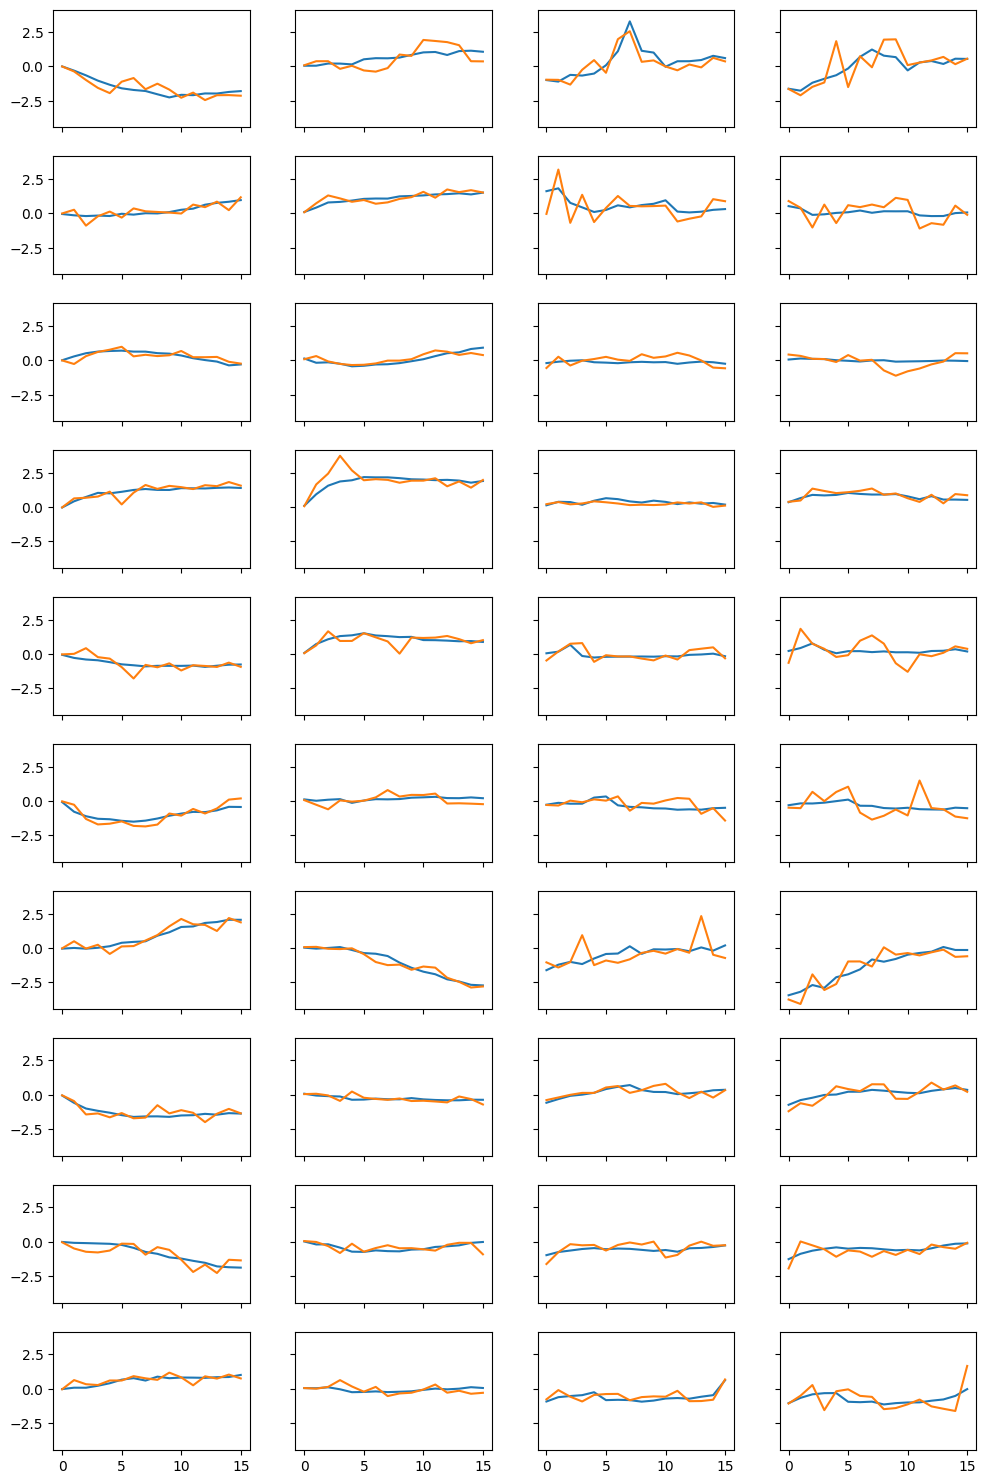

In [128]:
size = 10
rand_idx = np.random.choice(X_train.shape[0], size, replace=False)

orig_vec = X_train[rand_idx,:,:]
orig_list = orig_vec.reshape(orig_vec.shape[0],16,4)

pred_vec = cae.predict(orig_vec)
pred_list = pred_vec.reshape(pred_vec.shape[0],16,4)

plot_autoencoder_by_time(orig_list,pred_list)

In [129]:
cae.get_layer('embedding').predict(x)

In [20]:
dcec = DCEC(input_shape=x_n.shape[1:], filters=[32, 64, 128, 3], n_clusters=3)
dcec.pretra

In [98]:
dcec = DCEC(input_shape=x_n.shape[1:], filters=[32, 64, 128, 3], n_clusters=3)
dcec.load_weights('./results/temp_exp/dcec_model_0.h5')

In [131]:
X_train[:1,:,:].shape

(1, 4, 4, 4)

In [134]:
hidden = cae.get_layer(name='embedding').output
encoder = Model(inputs=cae.input, outputs=hidden)

In [149]:
latent.shape

(29808, 8)

In [153]:
y = np.load(r'C:\Projects\TAU\DL-Workshop\Git Folder\DL-WORKSHOP\npy_files\labels_All16.npy')
y

from sklearn.preprocessing import label_binarize


array(['G3', 'G3', 'G3', ..., 'D3', 'D3', 'D3'], dtype='<U2')

In [145]:
latent_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent)

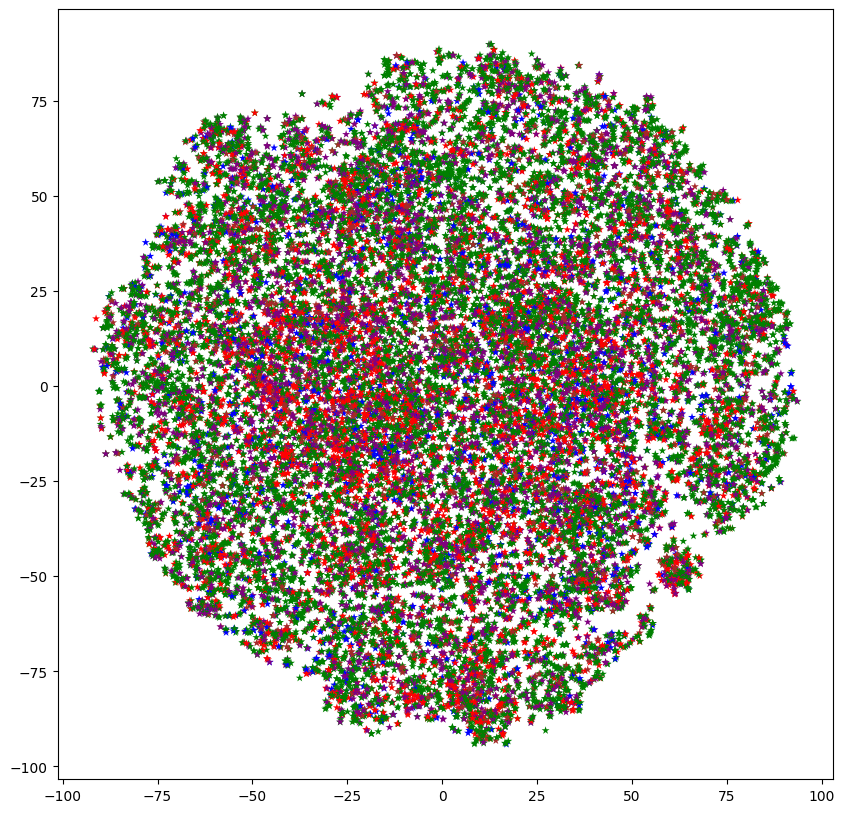

In [156]:
from sklearn.preprocessing import LabelEncoder

wells_to_genetype_dict = {
  **dict.fromkeys(['D2','D3','D4','G5','G6','G7'], "control"),
  **dict.fromkeys(['D5','D6','D7'], "Grb2"),
  **dict.fromkeys(['F2','F3','F4'], "Gab1"),
  **dict.fromkeys(['G2','G3','G4'], "MET+Gab1"),
  **dict.fromkeys(['E5','E6',"E7"], "MET+Grb2")
}

y2treat = pd.Series(y).map(wells_to_genetype_dict)
le = LabelEncoder()
le.fit(list(wells_to_genetype_dict.values()))
treat2lbl = le.transform(y2treat.values)

color_options = ['red','blue','purple','brown','green', 'pink', 'black']
colors = [color_options[i] for i in treat2lbl]

plt.subplots(figsize = (10,10))
plt.scatter(latent_embedded[:, 0], latent_embedded[:, 1],c = colors , marker='*', linewidths=0)

In [136]:
latent = encoder.predict(X_train)

In [142]:
import umap

In [143]:
mapper = umap.UMAP().fit(latent)
umap.plot.points(mapper)

AttributeError: module 'umap' has no attribute 'UMAP'

In [140]:
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(latent)


AttributeError: module 'umap' has no attribute 'UMAP'

In [95]:
pd.Series(dcec.predict(x)).value_counts()

ValueError: in user code:

    File "c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_15" is incompatible with the layer: expected shape=(None, 25, 5), found shape=(None, 32, 5)


In [81]:
def plot_clustering(latent, clusters):

    clusters = clusters[:latent.shape[0]] # because of weird batch_size
    color_options = ['red','blue','purple','brown','green','yellow','black','pink']

    colors = [color_options[int(i)] for i in clusters]

    latent_pca = TruncatedSVD(n_components=2).fit_transform(latent)
    latent_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(latent)

    fig, axs = plt.subplots(2, figsize=(5,10),sharey=False,sharex=False)

    axs[0].scatter(latent_pca[:, 0], latent_pca[:, 1], c=colors, marker='*', linewidths=0)
    axs[0].set_title('PCA')

    axs[1].scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=colors, marker='*', linewidths=0)
    axs[1].set_title('tSNE')

    fig.show()

In [82]:
latent = dcec.extract_feature(x)
clusters = dcec.predict(x)

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\asafavra\AppData\Local\Temp\ipykernel_32328\3952059493.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


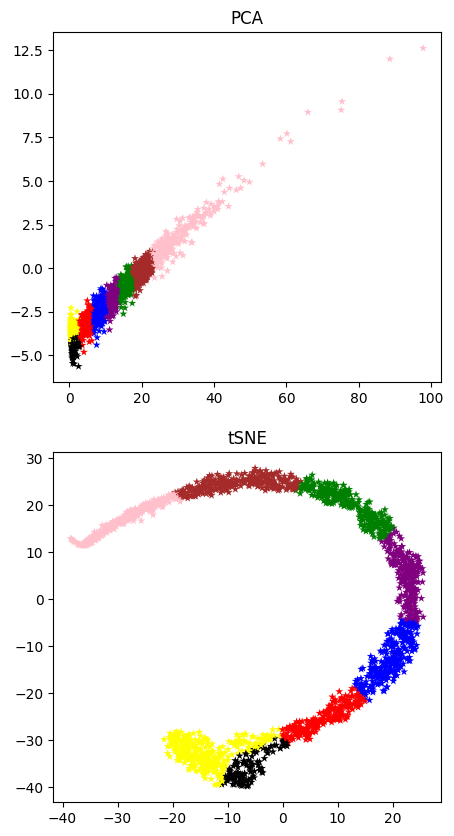

In [83]:
plot_clustering(latent,clusters)

In [70]:
def plot_representatives(rep_groups):
    cmap = cm.get_cmap(name='rainbow')
    l = len(rep_groups[0])
    L = len(rep_groups)
    fig, axs = plt.subplots(l,L, figsize=(10,20),sharey=True,sharex=True)
    fig.tight_layout()
    for j,reps in enumerate(rep_groups):
        for i,rep in enumerate(reps):
            axs[i,j].plot(rep[:,0],rep[:,1],color=cmap(np.arange(25)))
    fig.show()

In [ ]:
X_C0 = np.array([x for x,clust in zip(x,clusters) if clust == 0])
X_C1 = np.array([x for x,clust in zip(x,clusters) if clust == 1])
X_C2 = np.array([x for x,clust in zip(x,clusters) if clust == 2])

ValueError: array([[0.5       , 0.        , 1.        , 1.        ],
       [0.49215686, 0.01231966, 0.99998103, 1.        ],
       [0.48431373, 0.02463745, 0.99992411, 1.        ],
       [0.47647059, 0.0369515 , 0.99982925, 1.        ],
       [0.46862745, 0.04925994, 0.99969645, 1.        ],
       [0.46078431, 0.06156091, 0.99952572, 1.        ],
       [0.45294118, 0.07385253, 0.99931706, 1.        ],
       [0.44509804, 0.08613294, 0.99907048, 1.        ],
       [0.4372549 , 0.09840028, 0.99878599, 1.        ],
       [0.42941176, 0.11065268, 0.9984636 , 1.        ],
       [0.42156863, 0.12288829, 0.99810333, 1.        ],
       [0.41372549, 0.13510525, 0.99770518, 1.        ],
       [0.40588235, 0.1473017 , 0.99726917, 1.        ],
       [0.39803922, 0.15947579, 0.99679532, 1.        ],
       [0.39019608, 0.17162568, 0.99628365, 1.        ],
       [0.38235294, 0.18374952, 0.99573418, 1.        ],
       [0.3745098 , 0.19584547, 0.99514692, 1.        ],
       [0.36666667, 0.20791169, 0.9945219 , 1.        ],
       [0.35882353, 0.21994636, 0.99385914, 1.        ],
       [0.35098039, 0.23194764, 0.99315867, 1.        ],
       [0.34313725, 0.24391372, 0.99242051, 1.        ],
       [0.33529412, 0.25584278, 0.9916447 , 1.        ],
       [0.32745098, 0.267733  , 0.99083125, 1.        ],
       [0.31960784, 0.27958259, 0.98998021, 1.        ],
       [0.31176471, 0.29138975, 0.98909161, 1.        ]]) is not a valid value for color

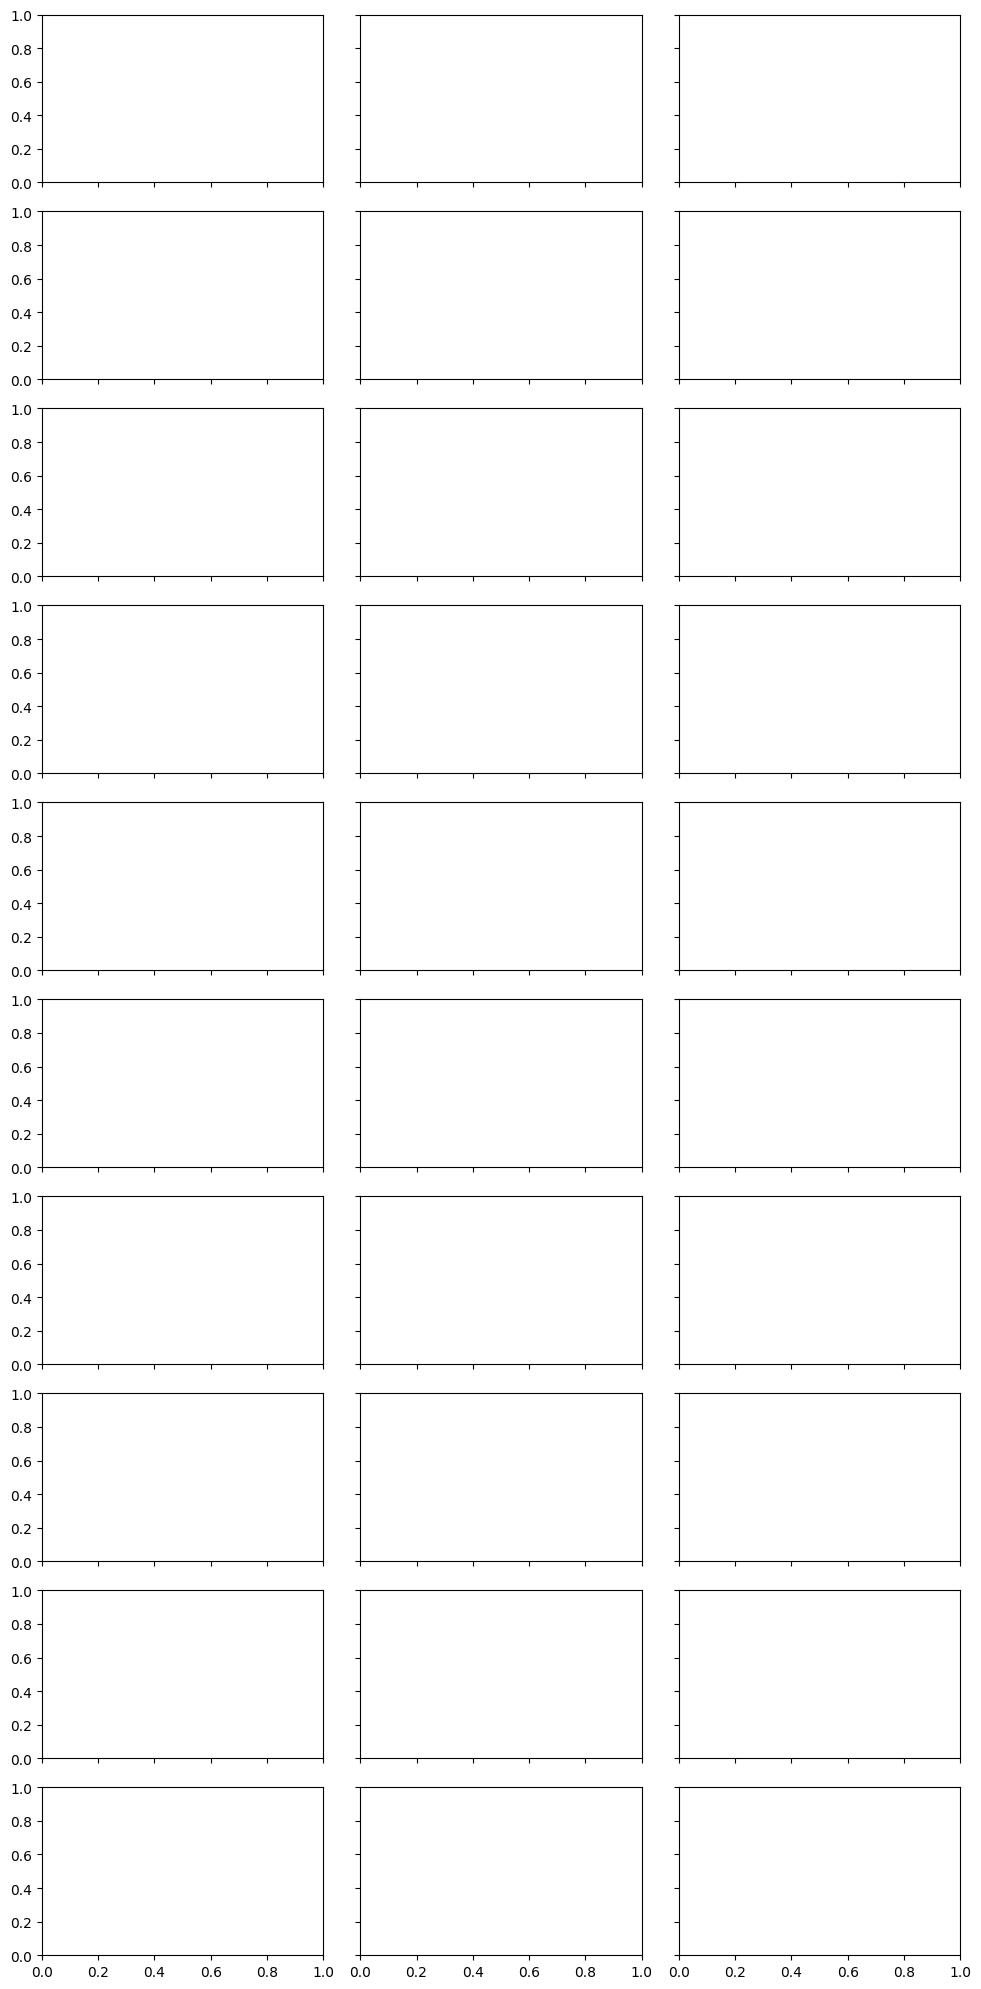

In [71]:
X_C0 = np.array([x for x,clust in zip(x,clusters) if clust == 0])
X_C1 = np.array([x for x,clust in zip(x,clusters) if clust == 1])
X_C2 = np.array([x for x,clust in zip(x,clusters) if clust == 2])

n_reps = 10
representatives_C0 = X_C0[np.random.choice(X_C0.shape[0], n_reps, replace=False)]
representatives_C1 = X_C1[np.random.choice(X_C1.shape[0], n_reps, replace=False)]
representatives_C2 = X_C2[np.random.choice(X_C2.shape[0], n_reps, replace=False)]

plot_representatives([representatives_C0,representatives_C1,representatives_C2])